
=== Metrics for Each Target ===
                 Target           MSE       MAE        R2
0  SO2TONS_per_LOADMWBA  2.596487e-10  0.000013 -0.008869
1  SO2TONS_per_LOADMWBT  4.559694e-11  0.000001 -0.013113
2  NH3TONS_per_LOADMWBA  1.677966e-07  0.000164 -0.001887
3  NH3TONS_per_LOADMWBT  1.452335e-07  0.000031 -0.001873
4  NOXTONS_per_LOADMWBA  4.913275e-07  0.000311 -0.063222
5  NOXTONS_per_LOADMWBT  4.682982e-07  0.000184 -0.065868
6   COTONS_per_LOADMWBA  4.304996e-07  0.000195 -0.037897
7   COTONS_per_LOADMWBT  4.341442e-07  0.000162 -0.058165

=== Comparison for 2022-07-15 ===
                        Actual  Predicted
SO2TONS_per_LOADMWBA  0.000031   0.000038
SO2TONS_per_LOADMWBT  0.000003   0.000003
NH3TONS_per_LOADMWBA  0.000178   0.000325
NH3TONS_per_LOADMWBT  0.000015   0.000028
NOXTONS_per_LOADMWBA  0.000613   0.000832
NOXTONS_per_LOADMWBT  0.000051   0.000171
COTONS_per_LOADMWBA   0.000104   0.000287
COTONS_per_LOADMWBT   0.000009   0.000136

=== Permutation Importances (Av

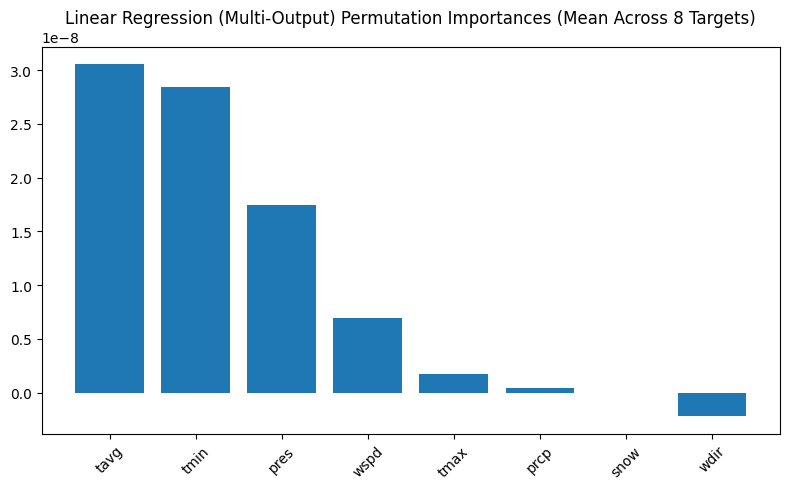

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score
)

# 1. Load Dataset
url = "https://raw.githubusercontent.com/apownukepcc/spring-2025-datathon/main/009-Dataset-For-Predictions-With-Specific-Emissions.csv"
df = pd.read_csv(url)

# 2. Convert date column and define the special test date
df["date"] = pd.to_datetime(df["date"])
specific_test_date = pd.to_datetime("2022-07-15")
if specific_test_date not in df["date"].values:
    raise ValueError(f"No data available for {specific_test_date.date()}")

# Extract and remove that row
specific_test_row = df[df["date"] == specific_test_date]
df = df[df["date"] != specific_test_date]

# 3. Define features and targets
feature_cols = ["tavg", "tmin", "tmax", "prcp", "snow", "wdir", "wspd", "pres"]
target_cols = [
    "SO2TONS_per_LOADMWBA", "SO2TONS_per_LOADMWBT",
    "NH3TONS_per_LOADMWBA", "NH3TONS_per_LOADMWBT",
    "NOXTONS_per_LOADMWBA", "NOXTONS_per_LOADMWBT",
    "COTONS_per_LOADMWBA",  "COTONS_per_LOADMWBT"
]

# Drop rows missing relevant columns
df = df.dropna(subset=feature_cols + target_cols)

# 4. Train/Test Split
X = df[feature_cols]
y = df[target_cols]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Append the special-date row to X_test, y_test
X_test = pd.concat([X_test, specific_test_row[feature_cols]])
y_test = pd.concat([y_test, specific_test_row[target_cols]])

# 5. Multi-Output Linear Regression
# scikit-learn's LinearRegression can handle multi-output directly,
# but we wrap with MultiOutputRegressor for consistency with other methods
lin = LinearRegression()
multi_lin = MultiOutputRegressor(lin)
multi_lin.fit(X_train, y_train)

# 6. Predictions & Basic Metrics
predictions = multi_lin.predict(X_test)

mse_all = mean_squared_error(y_test, predictions, multioutput='raw_values')
mae_all = mean_absolute_error(y_test, predictions, multioutput='raw_values')
r2_all  = r2_score(y_test, predictions, multioutput='raw_values')

results = pd.DataFrame({
    "Target": target_cols,
    "MSE": mse_all,
    "MAE": mae_all,
    "R2": r2_all
})

print("\n=== Metrics for Each Target ===")
print(results)

# Compare predictions for the special test date
pred_df = pd.DataFrame(predictions, columns=target_cols, index=y_test.index)
special_date_pred = pred_df.iloc[-1]
special_date_true = y_test.iloc[-1]

print(f"\n=== Comparison for {specific_test_date.date()} ===")
comparison_df = pd.DataFrame({"Actual": special_date_true, "Predicted": special_date_pred})
print(comparison_df)

# 7. Permutation Feature Importance
# Linear Regression does not provide feature_importances_, so we use permutation_importance.
# We'll do this separately for each target column, then average.

permutation_means = []
for i, estimator in enumerate(multi_lin.estimators_):
    # Permutation importance for the i-th target
    perm_result = permutation_importance(
        estimator,
        X_test,
        y_test.iloc[:, i],  # i-th column of y_test
        n_repeats=5,
        random_state=42,
        scoring='neg_mean_squared_error'
    )
    permutation_means.append(perm_result.importances_mean)

# Convert to array and average
permutation_means = np.array(permutation_means)  # shape = (num_targets, num_features)
avg_importances = permutation_means.mean(axis=0)

# Sort descending
sorted_idx = np.argsort(avg_importances)[::-1]

print("\n=== Permutation Importances (Averaged Across Targets) ===")
for idx in sorted_idx:
    print(f"{feature_cols[idx]}: {avg_importances[idx]:.4e}")

# 8. Plot the Averaged Permutation Importances
plt.figure(figsize=(8,5))
plt.bar(range(len(feature_cols)), avg_importances[sorted_idx], align='center')
plt.xticks(range(len(feature_cols)), [feature_cols[i] for i in sorted_idx], rotation=45)
plt.title("Linear Regression (Multi-Output) Permutation Importances (Mean Across 8 Targets)")
plt.tight_layout()
plt.show()
